In [11]:
from kucoin.client import Client
from kucoin.asyncio import KucoinSocketManager
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import asyncio
import plotly.express as px
from pathlib import Path
import time as t
import threading
import requests
from requests import Request, Session
import datetime
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

%matplotlib inline

In [12]:
from dotenv import load_dotenv
load_dotenv()

True

In [13]:
api_key = os.getenv("KUCOIN_API_KEY")
secret_key = os.getenv("KUCOIN_SECRET_KEY")
passphrase = os.getenv("KUCOIN_PASSPHRASE")
cmc_key = os.getenv('CMC_KEY')
client = Client(api_key,secret_key,passphrase)
client

In [14]:
accounts = client.get_accounts()
dfkcs = pd.DataFrame(accounts)
dfkcs2 = dfkcs.groupby('currency').sum()
dfkcs2.to_csv('dfkcs2.csv')

***_COIN MARKET CAP DATA_***

In [17]:
url = 'https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest'
parameters = {

}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': cmc_key,
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  cmc_data = json.loads(response.text)
  print(cmc_data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

{'status': {'timestamp': '2021-11-10T20:46:26.237Z', 'error_code': 0, 'error_message': None, 'elapsed': 15, 'credit_count': 1, 'notice': None}, 'data': {'active_cryptocurrencies': 7278, 'total_cryptocurrencies': 13967, 'active_market_pairs': 48173, 'active_exchanges': 430, 'total_exchanges': 1525, 'eth_dominance': 19.249919424703, 'btc_dominance': 43.686491481939, 'eth_dominance_yesterday': 19.34582831, 'btc_dominance_yesterday': 43.527431, 'eth_dominance_24h_percentage_change': -0.095908885297, 'btc_dominance_24h_percentage_change': 0.159060481939, 'defi_volume_24h': 24457386238.4281, 'defi_volume_24h_reported': 24457386238.4281, 'defi_market_cap': 172124302097.12164, 'defi_24h_percentage_change': 8.873333836972, 'stablecoin_volume_24h': 110910930368.5211, 'stablecoin_volume_24h_reported': 110910930368.5211, 'stablecoin_market_cap': 135783176361.29036, 'stablecoin_24h_percentage_change': 2.149766895152, 'derivatives_volume_24h': 228609446155.93042, 'derivatives_volume_24h_reported': 2

In [18]:
cmc_mc = cmc_data['data']['quote']['USD']['total_market_cap']
cmc_mc

2867968755179.7188

In [26]:
cmc_df = cmc_data['data']
cmc_df

{'active_cryptocurrencies': 7278,
 'total_cryptocurrencies': 13967,
 'active_market_pairs': 48173,
 'active_exchanges': 430,
 'total_exchanges': 1525,
 'eth_dominance': 19.249919424703,
 'btc_dominance': 43.686491481939,
 'eth_dominance_yesterday': 19.34582831,
 'btc_dominance_yesterday': 43.527431,
 'eth_dominance_24h_percentage_change': -0.095908885297,
 'btc_dominance_24h_percentage_change': 0.159060481939,
 'defi_volume_24h': 24457386238.4281,
 'defi_volume_24h_reported': 24457386238.4281,
 'defi_market_cap': 172124302097.12164,
 'defi_24h_percentage_change': 8.873333836972,
 'stablecoin_volume_24h': 110910930368.5211,
 'stablecoin_volume_24h_reported': 110910930368.5211,
 'stablecoin_market_cap': 135783176361.29036,
 'stablecoin_24h_percentage_change': 2.149766895152,
 'derivatives_volume_24h': 228609446155.93042,
 'derivatives_volume_24h_reported': 228609446155.93042,
 'derivatives_24h_percentage_change': 6.292094717862,
 'quote': {'USD': {'total_market_cap': 2867968755179.7188,


***_INDEX TOKENS_***

In [6]:
# Request data from Kuc API & Convert to Json
btc = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=BTC-USDT&startAt=1620360000&endAt=0')
btc_j = btc.json()

In [7]:
# Convert json to DataFrame
btc_df = pd.DataFrame(btc_j['data'])

In [8]:
# Rename Date, Open, & Close columns and remove others
btc_df.rename(columns={0:'Date',1:'Open',2:'Close'}, inplace=True)

btc_df.drop(columns = [3,4,5,6], inplace=True)
btc_df

,Date,Open,Close
0,1636560000,68339.8,67677.2
1,1636531200,66426,68339.8
2,1636502400,66943,66426
3,1636473600,66760.8,66941.7
4,1636444800,67856.5,66760.7
...,...,...,...
558,1620489600,57596.8,58863.1
559,1620460800,58455.6,57596.8
560,1620432000,57307.2,58455.7
561,1620403200,57518.3,57307.3


In [9]:
# Create A DF with Median Price 

btc_median = btc_df[['Open','Close']].astype(float)

btc_median['Median'] = btc_median[['Open','Close']].mean(axis=1)
btc_median = btc_median['Median']
btc_median

0      68008.50
1      67382.90
2      66684.50
3      66851.25
4      67308.60
         ...   
558    58229.95
559    58026.20
560    57881.45
561    57412.80
562    56646.50
Name: Median, Length: 563, dtype: float64

In [15]:
btc_df_date = pd.to_datetime(btc_df['Date'], unit='s')
btc_date = [btc_df_date, btc_median]
btc_result = pd.concat(btc_date, axis=1, join = 'outer')
#btc__fin = pd.DataFrame(btc_result)
btc_plot = btc_result.set_index('Date')

<AxesSubplot:xlabel='Date'>

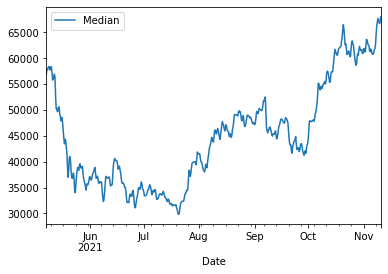

In [16]:
btc_plot.plot()

In [ ]:
eth = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=ETH-USDT&startAt=1566777600&endAt=0')
eth_j = eth.json()
eth_j

In [ ]:
bnb = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=BNB-USDT&startAt=1566777600&endAt=0')
bnb_j = bnb.json()
bnb_j

***_MEME TOKENS_***

In [ ]:
doge = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=DOGE-USDT&startAt=1566777600&endAt=0')
doge_j = doge.json()
doge_j

In [ ]:
elon = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=ELON-USDT&startAt=1566777600&endAt=0')
elon_j = elon.json()
elon_j

***_DEFI TOKENS_***

In [ ]:
uni = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=UNI-USDT&startAt=1566777600&endAt=0')
uni_j = uni.json()
uni_j

In [ ]:
luna = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=LUNA-USDT&startAt=1566777600&endAt=0')
luna_j = luna.json()
luna_j

In [ ]:
avax = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=AVAX-USDT&startAt=1566777600&endAt=0')
avax_j = avax.json()
avax_j

***_STORAGE TOKENS_***

In [ ]:
fil = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=FIL-USDT&startAt=1566777600')
fil_j = fil.json()
fil_j

In [ ]:
btt = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=BTT-USDT&startAt=1566777600')
btt_j = btt.json()
btt_j

In [ ]:
storj = requests.get('https://api.kucoin.com/api/v1/market/candles?type=8hour&symbol=STORJ-USDT&startAt=1566777600')
storj_j = storj.json()
storj_j